# Introduction

For this analysis, my research question would be what factors are associated with COVID-19 infection rates in United States counties. I would be utilizing various datasets concerning county health information, county COVID-19 infection rates, county population densities, and state political affiliation. In turn, I would attempt to identify and evaluate risk factors connected to infection rates by doing multiple regression analysis. The resultant linear regression model would be used mainly for interpretation. The outcome of the study, if deemed to be insightful and significant, can be used to access a population's vulnerability to COVID-19 based on the community's characteristics from the reference point of United States counties.  

In [340]:
# Import necessary libraries 

import pandas as pd
import numpy as np 
import altair as alt
import statsmodels.formula.api as smf
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

# Data overview

Let's take a look at the datasets this analysis will be using. A few of them  are put together by crawling wiki pages. The rest are from what are provided officially.

In [341]:
# https://github.com/nytimes/covid-19-data
# Cumulative counts of coronavirus cases in the US at the county level
county_infection = pd.read_csv('relevant_data/us-counties.csv')

In [342]:
county_infection.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


In [343]:
county_infection.tail()

,date,county,state,fips,cases,deaths
141398,2020-05-13,Sublette,Wyoming,56035.0,3,0
141399,2020-05-13,Sweetwater,Wyoming,56037.0,20,0
141400,2020-05-13,Teton,Wyoming,56039.0,99,1
141401,2020-05-13,Uinta,Wyoming,56041.0,9,0
141402,2020-05-13,Washakie,Wyoming,56043.0,7,0


> The latest date of the data is May 13th, 2020.

In [344]:
county_infection[(county_infection['state'] == 'Illinois') & (county_infection['county'] == 'Cook')]

,date,county,state,fips,cases,deaths
3,2020-01-24,Cook,Illinois,17031.0,1,0
6,2020-01-25,Cook,Illinois,17031.0,1,0
11,2020-01-26,Cook,Illinois,17031.0,1,0
16,2020-01-27,Cook,Illinois,17031.0,1,0
21,2020-01-28,Cook,Illinois,17031.0,1,0
...,...,...,...,...,...,...
127415,2020-05-09,Cook,Illinois,17031.0,51674,2264
130328,2020-05-10,Cook,Illinois,17031.0,52655,2317
133240,2020-05-11,Cook,Illinois,17031.0,53381,2361
136151,2020-05-12,Cook,Illinois,17031.0,55470,2449


In [345]:
county_infection[(county_infection['state'] == 'California') & (county_infection['county'] == 'Santa Clara')]

,date,county,state,fips,cases,deaths
36,2020-01-31,Santa Clara,California,6085.0,1,0
42,2020-02-01,Santa Clara,California,6085.0,1,0
50,2020-02-02,Santa Clara,California,6085.0,2,0
58,2020-02-03,Santa Clara,California,6085.0,2,0
66,2020-02-04,Santa Clara,California,6085.0,2,0
...,...,...,...,...,...,...
127045,2020-05-09,Santa Clara,California,6085.0,2307,131
129957,2020-05-10,Santa Clara,California,6085.0,2339,131
132869,2020-05-11,Santa Clara,California,6085.0,2341,131
135780,2020-05-12,Santa Clara,California,6085.0,2364,134


> It seems like each county's data starts with the first case of infection and then contains each subsequent day's cumulative count.

In [346]:
# https://en.wikipedia.org/wiki/County_(United_States)
# County population and density
county_population = pd.read_csv('relevant_data/county-population.csv')

In [347]:
county_population.head()

,state,county,population,land_area_km,density_km
0,Alabama,Autauga,54571,1540,35.436
1,Alabama,Baldwin,182265,4118,44.261
2,Alabama,Barbour,27457,2292,11.979
3,Alabama,Bibb,22915,1612,14.215
4,Alabama,Blount,57322,1670,34.325


In [348]:
# https://en.wikipedia.org/wiki/Political_party_strength_in_U.S._states
# https://en.wikipedia.org/wiki/List_of_United_States_governors
# State party affiliation based on house representation
state_party_line = pd.read_csv('relevant_data/state_party_line.csv')

In [349]:
state_party_line.head()

,state,state_house_blue_perc,state_governor_party
0,Alabama,22.86,red
1,Alaska,35.00,red
2,Arizona,43.33,red
3,Arkansas,25.71,red
4,California,72.50,blue


In [350]:
# Source: https://www.countyhealthrankings.org/
# Access: https://app.namara.io/#/data_sets/579ee1c6-8f66-418c-9df9-d7b5b618c774?organizationId=5ea77ea08fb3bf000c9879a1
# County health information
county_health = pd.read_csv('relevant_data/us-county-health-rankings-2020.csv')

In [351]:
county_health.head()

,fips,state,county,num_deaths,years_of_potential_life_lost_rate,95percent_ci_low,95percent_ci_high,quartile,ypll_rate_aian,ypll_rate_aian_95percent_ci_low,...,percent_hispanic,num_non_hispanic_white,percent_non_hispanic_white,num_not_proficient_in_english,percent_not_proficient_in_english,95percent_ci_low_39,95percent_ci_high_39,percent_female,num_rural,percent_rural
0,1000,Alabama,NaN,81791.0,9942.794666,9840.535949,10045.053384,NaN,NaN,NaN,...,4.443264,3197324,65.413428,48517,1.061048,1.006759,1.115337,51.633032,1957932.0,40.963183
1,1001,Alabama,Autauga,791.0,8128.591190,7283.340731,8973.841649,1.0,NaN,NaN,...,2.965774,41316,74.308016,426,0.820225,0.347891,1.292558,51.448715,22921.0,42.002162
2,1003,Alabama,Baldwin,2967.0,7354.122530,6918.554269,7789.690790,1.0,NaN,NaN,...,4.646779,181201,83.111337,1068,0.543517,0.347271,0.739763,51.538377,77060.0,42.279099
3,1005,Alabama,Barbour,472.0,10253.573403,8782.217281,11724.929524,2.0,NaN,NaN,...,4.276355,11356,45.641252,398,1.631683,0.824903,2.438462,47.216752,18613.0,67.789635
4,1007,Alabama,Bibb,471.0,11977.539484,10344.064842,13611.014126,3.0,NaN,NaN,...,2.625000,16708,74.589286,57,0.268210,0.000000,0.807504,46.781250,15663.0,68.352607


In [352]:
county_health.columns[:75]

Index(['fips', 'state', 'county', 'num_deaths',
       'years_of_potential_life_lost_rate', '95percent_ci_low',
       '95percent_ci_high', 'quartile', 'ypll_rate_aian',
       'ypll_rate_aian_95percent_ci_low', 'ypll_rate_aian_95percent_ci_high',
       'ypll_rate_asian', 'ypll_rate_asian_95percent_ci_low',
       'ypll_rate_asian_95percent_ci_high', 'ypll_rate_black',
       'ypll_rate_black_95percent_ci_low', 'ypll_rate_black_95percent_ci_high',
       'ypll_rate_hispanic', 'ypll_rate_hispanic_95percent_ci_low',
       'ypll_rate_hispanic_95percent_ci_high', 'ypll_rate_white',
       'ypll_rate_white_95percent_ci_low', 'ypll_rate_white_95percent_ci_high',
       'percent_fair_or_poor_health', '95percent_ci_low_2',
       '95percent_ci_high_2', 'quartile_2',
       'average_number_of_physically_unhealthy_days', '95percent_ci_low_3',
       '95percent_ci_high_3', 'quartile_3',
       'average_number_of_mentally_unhealthy_days', '95percent_ci_low_4',
       '95percent_ci_high_4', 'quar

> This dataset contains extensive information about a county's health, including the rankings, quantiles, rates, and percentages of numerous demographic as well as health qualities. Of the many measurements of each quality, we probably only need one or two to avoid duplication. In addition, I will do a **factor analysis** on the columns to see if it makes sense.

For more information about these columns, please visit this [info](https://app.namara.io/#/data_sets/579ee1c6-8f66-418c-9df9-d7b5b618c774/info?organizationId=5ea77ea08fb3bf000c9879a1) page

# Data wrangling

In this section, we want to prepare our data for further exploration and analysis. 

In [353]:
# Aggregate data related to county infection and basic characteristics
county = county_infection.merge(
    county_population, left_on=['county', 'state'], right_on=['county', 'state']
).merge(
    state_party_line, left_on=['state'], right_on=['state']
)

In [354]:
county.sample(5)

,date,county,state,fips,cases,deaths,population,land_area_km,density_km,state_house_blue_perc,state_governor_party
41903,2020-04-08,Cumberland,North Carolina,37051.0,64,0,332766,1704,195.285,42.00,blue
32126,2020-05-05,Lowndes,Georgia,13185.0,166,4,114552,1305,87.779,37.50,red
16698,2020-03-26,Medina,Texas,48325.0,1,0,50066,3440,14.554,38.71,red
73913,2020-04-11,Comanche,Oklahoma,40031.0,49,0,124098,2769,44.817,18.75,red
105705,2020-05-02,Antrim,Michigan,26009.0,10,0,23598,1559,15.137,42.11,blue


Let's look at the statistics of the counted days for the counties

In [355]:
# Count the number of days each county data has
def count_days(series):
    time_series = pd.to_datetime(series)
    first_date = time_series.iloc[0]
    last_date = time_series.iloc[-1]
    
    return (last_date - first_date).days + 1

In [356]:
grouped_county = county.groupby(['state', 'county']).agg(days_counted=('date', count_days))

In [357]:
grouped_county.describe()

,days_counted
count,2758.000000
mean,48.719362
std,12.420495
min,1.000000
25%,43.000000
50%,50.000000
75%,56.000000
max,114.000000


In [358]:
grouped_county.shape

(2758, 1)

> We have 2758 counties in the data. The minimum amount of days counted for a county is only one, while the maximum is about two and a half months. I am happy that the median is 50 days. Ideally, I want all counties in the analysis to have at least two months worth of data so that any of its heath characteristics can have a decent chance of exerting its influence if there could be any at all. With the current data and analysis, I will only include counties with 50 day worth of data to maximize the representativeness of the eventual infection picture and not exclude too much data. Please understand that I'm not a domain expert. I apologize that this cutoff point seems rather arbitrary, but I hope the rationale makes sense domain-wise.

With that said, for the next step, we want to group the infection data by counties and create a bunch of aggregated columns including counted days, confirmed infection in the percentage of county population, death rate, and raw infection counts. We will also calculate those columns for the cutoff point of 45 days so that we can do the analysis without accounting for the number of days for model simplicity. This is also where we will exclude counties that have less than 45 days of data.

In [288]:
# Find the value at the 50 day mark
def county_cumulative_days(series, days = 50):
    # This may not be 100% accurate because perhaps some days are missing, 
    # but that seems to happen rarely. So this should be accurate enough.
    if len(series) < days:
        return series.iloc[-1]
    else:
        return series.iloc[days - 1]

In [359]:
# Group our data in terms of county and aggregate some columns to show overall infection rate 
# and death rate as well as at the 45 day mark
def group_county_data(data):
    grouped_data = data.groupby(['state', 'county']).agg(
        population=('population', lambda x: x.iloc[-1]),
        density_km=('density_km', lambda x: x.iloc[-1]),
        state_house_blue_perc=('state_house_blue_perc', lambda x: x.iloc[-1]),
        state_governor_party=('state_governor_party', lambda x: x.iloc[-1]),
        days_counted=('date', count_days),
        case_sum=('cases', lambda x: x.iloc[-1]),
        death_sum=('deaths', lambda x: x.iloc[-1]),
        case_count_50_days=('cases', county_cumulative_days),
        death_count_50_days=('deaths', county_cumulative_days)
    )
    
    grouped_data = grouped_data[grouped_data['days_counted'] >= 50]
    grouped_data['infection_rate'] = grouped_data['case_sum']/grouped_data['population']*100
    grouped_data['death_rate'] = grouped_data['death_sum']/grouped_data['case_sum']*100
    grouped_data = grouped_data[grouped_data['infection_rate'] != float("inf")]
    grouped_data['infection_rate_50_days'] = grouped_data['case_count_50_days']/grouped_data['population']*100
    grouped_data['death_rate_50_days'] = grouped_data['death_count_50_days']/grouped_data['case_count_50_days']*100
    
    return grouped_data.reset_index()

In [360]:
grouped_county = group_county_data(county)

In [361]:
grouped_county

,state,county,population,density_km,state_house_blue_perc,state_governor_party,days_counted,case_sum,death_sum,case_count_50_days,death_count_50_days,infection_rate,death_rate,infection_rate_50_days,death_rate_50_days
0,Alabama,Autauga,54571,35.436,22.86,red,51,93,4,61,3,0.170420,4.301075,0.111781,4.918033
1,Alabama,Baldwin,182265,44.261,22.86,red,61,231,7,168,3,0.126739,3.030303,0.092173,1.785714
2,Alabama,Blount,57322,34.325,22.86,red,50,45,0,44,0,0.078504,0.000000,0.076759,0.000000
3,Alabama,Butler,20947,10.411,22.86,red,50,230,6,162,3,1.098009,2.608696,0.773380,1.851852
4,Alabama,Calhoun,118572,75.572,22.86,red,57,127,3,93,3,0.107108,2.362205,0.078433,3.225806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458,Wyoming,Natrona,78621,5.684,10.00,red,55,48,0,48,0,0.061052,0.000000,0.061052,0.000000
1459,Wyoming,Park,28702,1.596,10.00,red,58,1,0,1,0,0.003484,0.000000,0.003484,0.000000
1460,Wyoming,Sheridan,29596,4.529,10.00,red,64,16,0,16,0,0.054061,0.000000,0.054061,0.000000
1461,Wyoming,Sweetwater,45267,1.676,10.00,red,51,20,0,19,0,0.044182,0.000000,0.041973,0.000000


In [362]:
grouped_county.sample(5)

,state,county,population,density_km,state_house_blue_perc,state_governor_party,days_counted,case_sum,death_sum,case_count_50_days,death_count_50_days,infection_rate,death_rate,infection_rate_50_days,death_rate_50_days
581,Maryland,Caroline,32718,38.765,68.09,red,54,177,0,98,0,0.540987,0.000000,0.299529,0.000000
476,Kansas,Mitchell,6355,3.505,27.50,blue,53,3,0,3,0,0.047207,0.000000,0.047207,0.000000
1009,Ohio,Pickaway,55698,42.845,27.27,red,50,1958,25,1842,23,3.515387,1.276813,3.307121,1.248643
542,Louisiana,Lafourche,96318,25.267,30.77,blue,61,716,60,632,39,0.743371,8.379888,0.656160,6.170886
1433,Wisconsin,Jefferson,83686,58.075,42.42,blue,55,54,2,46,0,0.064527,3.703704,0.054967,0.000000


Next, let's tackle county health data.

In [363]:
# Remove state total rows first
county_health = county_health.dropna(subset=['county'])

Take a quick look over the data again.

In [364]:
county_health.sample(5)

,fips,state,county,num_deaths,years_of_potential_life_lost_rate,95percent_ci_low,95percent_ci_high,quartile,ypll_rate_aian,ypll_rate_aian_95percent_ci_low,...,percent_hispanic,num_non_hispanic_white,percent_non_hispanic_white,num_not_proficient_in_english,percent_not_proficient_in_english,95percent_ci_low_39,95percent_ci_high_39,percent_female,num_rural,percent_rural
282,8063,Colorado,Kit Carson,83.0,6570.646409,4601.999966,9096.544247,2.0,NaN,NaN,...,18.986458,5578,77.872400,284,3.919404,1.647971,6.190837,49.993020,4027.0,48.694075
927,20045,Kansas,Douglas,927.0,5371.231195,4873.758892,5868.703498,1.0,NaN,NaN,...,6.373728,95116,78.326032,1003,0.886865,NaN,NaN,50.163049,12205.0,11.012759
922,20035,Kansas,Cowley,584.0,9635.990122,8456.681785,10815.298459,4.0,NaN,NaN,...,11.036970,27890,79.192458,528,1.580933,0.872556,2.289310,49.696178,11256.0,30.998871
1147,22031,Louisiana,De Soto,462.0,9011.649791,7744.576244,10278.723337,1.0,NaN,NaN,...,2.966905,16109,58.714827,111,0.434783,0.000000,0.874002,51.771395,20595.0,77.262155
3035,53069,Washington,Wahkiakum,NaN,NaN,NaN,NaN,2.0,NaN,NaN,...,5.286941,3866,87.347492,21,0.518647,0.000000,2.162587,49.796656,3978.0,100.000000


In [365]:
county_health.columns

Index(['fips', 'state', 'county', 'num_deaths',
       'years_of_potential_life_lost_rate', '95percent_ci_low',
       '95percent_ci_high', 'quartile', 'ypll_rate_aian',
       'ypll_rate_aian_95percent_ci_low',
       ...
       'percent_hispanic', 'num_non_hispanic_white',
       'percent_non_hispanic_white', 'num_not_proficient_in_english',
       'percent_not_proficient_in_english', '95percent_ci_low_39',
       '95percent_ci_high_39', 'percent_female', 'num_rural', 'percent_rural'],
      dtype='object', length=507)

In [366]:
county_health.columns[:100]

Index(['fips', 'state', 'county', 'num_deaths',
       'years_of_potential_life_lost_rate', '95percent_ci_low',
       '95percent_ci_high', 'quartile', 'ypll_rate_aian',
       'ypll_rate_aian_95percent_ci_low', 'ypll_rate_aian_95percent_ci_high',
       'ypll_rate_asian', 'ypll_rate_asian_95percent_ci_low',
       'ypll_rate_asian_95percent_ci_high', 'ypll_rate_black',
       'ypll_rate_black_95percent_ci_low', 'ypll_rate_black_95percent_ci_high',
       'ypll_rate_hispanic', 'ypll_rate_hispanic_95percent_ci_low',
       'ypll_rate_hispanic_95percent_ci_high', 'ypll_rate_white',
       'ypll_rate_white_95percent_ci_low', 'ypll_rate_white_95percent_ci_high',
       'percent_fair_or_poor_health', '95percent_ci_low_2',
       '95percent_ci_high_2', 'quartile_2',
       'average_number_of_physically_unhealthy_days', '95percent_ci_low_3',
       '95percent_ci_high_3', 'quartile_3',
       'average_number_of_mentally_unhealthy_days', '95percent_ci_low_4',
       '95percent_ci_high_4', 'quar

> There are 507 columns. To reiterate my proposed course of action, we want to first get rid of many different measurements of the same quality and only keep the rates. We also want to remove some redundant columns such as population. The purpose is to hopefully keep the complexity under a managable level, while maintaining the values of the information.

In [367]:
excluded_column_words = [
    'quartile',
    'ci_high',
    'ci_low',
    'fips',
    'num',
    'denominator',
    'ratio',
    'population',
]

In [368]:
filtered_columns = county_health.columns[~county_health.columns.str.contains('|'.join(excluded_column_words))]

In [369]:
print(str(len(filtered_columns)) + ' columns remain!')

190 columns remain!


In [370]:
filtered_county_health = county_health[filtered_columns]

Next, let's merge the health data into the infection data, and check out the merged data.

In [371]:
county = grouped_county.merge(
    filtered_county_health, left_on=['county', 'state'], right_on=['county', 'state']
)

In [372]:
county

,state,county,population,density_km,state_house_blue_perc,state_governor_party,days_counted,case_sum,death_sum,case_count_50_days,...,percent_65_and_over,percent_black,percent_american_indian_alaska_native,percent_asian,percent_native_hawaiian_other_pacific_islander,percent_hispanic,percent_non_hispanic_white,percent_not_proficient_in_english,percent_female,percent_rural
0,Alabama,Autauga,54571,35.436,22.86,red,51,93,4,61,...,15.562670,19.343177,0.480207,1.224798,0.111509,2.965774,74.308016,0.820225,51.448715,42.002162
1,Alabama,Baldwin,182265,44.261,22.86,red,61,231,7,168,...,20.443350,8.783976,0.772399,1.150343,0.066966,4.646779,83.111337,0.543517,51.538377,42.279099
2,Alabama,Blount,57322,34.325,22.86,red,50,45,0,44,...,18.236515,1.462656,0.653527,0.319848,0.121024,9.571231,86.886238,1.724520,50.726141,89.951502
3,Alabama,Butler,20947,10.411,22.86,red,50,230,6,162,...,20.299797,44.557927,0.376016,1.316057,0.050813,1.509146,51.255081,0.494155,53.429878,71.232157
4,Alabama,Calhoun,118572,75.572,22.86,red,57,127,3,93,...,17.717476,20.850215,0.539916,0.964324,0.110258,3.910673,72.024992,0.991376,51.946586,33.696826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457,Wyoming,Natrona,78621,5.684,10.00,red,55,48,0,48,...,15.395311,1.161600,1.466220,0.827909,0.098591,8.581179,86.599254,0.731123,49.617645,14.449304
1458,Wyoming,Park,28702,1.596,10.00,red,58,1,0,1,...,23.206247,0.682035,0.944619,0.821852,0.057973,5.623380,90.915291,0.627835,50.194380,44.240383
1459,Wyoming,Sheridan,29596,4.529,10.00,red,64,16,0,16,...,20.993616,0.797142,1.366057,0.823603,0.112460,4.342937,91.482817,0.348727,49.793272,35.478775
1460,Wyoming,Sweetwater,45267,1.676,10.00,red,51,20,0,19,...,12.111217,1.145153,1.544680,1.010429,0.157952,16.083250,79.312908,1.633221,48.544749,10.916313


> We still have a lot of columns. Perhaps a lot of them have missing data for more than half of the data. We have no reasonable and accessible way of dealing with missing data here. We could fill in missing values from nearby counties, but that could be both erroneous and difficult. As a result, we will simply get rid of missing data in terms of columns and rows. Let's deal with columns first because we want to keep as many as rows as possible.

In [375]:
# Let's see the columns at near 90% cutoff points
county.dropna(thresh=1300, axis=1).info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1462 entries, 0 to 1461
Data columns (total 91 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   state                                               1462 non-null   object 
 1   county                                              1462 non-null   object 
 2   population                                          1462 non-null   int64  
 3   density_km                                          1462 non-null   float64
 4   state_house_blue_perc                               1462 non-null   float64
 5   state_governor_party                                1462 non-null   object 
 6   days_counted                                        1462 non-null   int64  
 7   case_sum                                            1462 non-null   int64  
 8   death_sum                                           1462 non-null   int64  
 9

> At the 90% row number cutoff point, we have a decent amount of columns. Most of the columns seem important, so we will try to keep most of them by setting the cutoff point at 1380 rows.

In [376]:
county.dropna(thresh=1380, axis=1).dropna()

,state,county,population,density_km,state_house_blue_perc,state_governor_party,days_counted,case_sum,death_sum,case_count_50_days,...,percent_65_and_over,percent_black,percent_american_indian_alaska_native,percent_asian,percent_native_hawaiian_other_pacific_islander,percent_hispanic,percent_non_hispanic_white,percent_not_proficient_in_english,percent_female,percent_rural
0,Alabama,Autauga,54571,35.436,22.86,red,51,93,4,61,...,15.562670,19.343177,0.480207,1.224798,0.111509,2.965774,74.308016,0.820225,51.448715,42.002162
1,Alabama,Baldwin,182265,44.261,22.86,red,61,231,7,168,...,20.443350,8.783976,0.772399,1.150343,0.066966,4.646779,83.111337,0.543517,51.538377,42.279099
2,Alabama,Blount,57322,34.325,22.86,red,50,45,0,44,...,18.236515,1.462656,0.653527,0.319848,0.121024,9.571231,86.886238,1.724520,50.726141,89.951502
3,Alabama,Butler,20947,10.411,22.86,red,50,230,6,162,...,20.299797,44.557927,0.376016,1.316057,0.050813,1.509146,51.255081,0.494155,53.429878,71.232157
4,Alabama,Calhoun,118572,75.572,22.86,red,57,127,3,93,...,17.717476,20.850215,0.539916,0.964324,0.110258,3.910673,72.024992,0.991376,51.946586,33.696826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,Wyoming,Laramie,94483,13.581,10.00,red,58,173,1,145,...,16.028128,2.417758,1.169981,1.365988,0.134376,14.795506,78.501859,0.823311,49.310944,19.784604
1457,Wyoming,Natrona,78621,5.684,10.00,red,55,48,0,48,...,15.395311,1.161600,1.466220,0.827909,0.098591,8.581179,86.599254,0.731123,49.617645,14.449304
1458,Wyoming,Park,28702,1.596,10.00,red,58,1,0,1,...,23.206247,0.682035,0.944619,0.821852,0.057973,5.623380,90.915291,0.627835,50.194380,44.240383
1459,Wyoming,Sheridan,29596,4.529,10.00,red,64,16,0,16,...,20.993616,0.797142,1.366057,0.823603,0.112460,4.342937,91.482817,0.348727,49.793272,35.478775


We are keeping a good amount of data. Let's go ahead with that decision.

In [377]:
county = county.dropna(thresh=1380, axis=1).dropna()

# Factor analysis

After data wrangling, we are still dealing with a large number of columns. If we continue with our anaylsis as is, it might suffer from the curse of dimensionality. Also, if we are to include interaction terms, the number of parameters could get close to the number of rows. Furthermore, there is a high chance that we will run into multicollinearity. For all these reaons, I have decided to run factor anaylsis as the next step to reduce dimensionality and find independant latent variables. Please refer to its [wiki](https://en.wikipedia.org/wiki/Factor_analysis) for more information on the technique itself.

In [378]:
# Exclude columns that won't be used as explanatory variables and can't used in factor analysis
excluded_columns = [
    'state',
    'county', 
    'population',
    'state_house_blue_perc',
    'state_governor_party',
    'days_counted', 
    'case_sum', 
    'death_sum', 
    'case_count_50_days',
    'death_count_50_days', 
    'infection_rate', 
    'death_rate',
    'infection_rate_50_days', 
    'death_rate_50_days'
]

In [379]:
county_non_factor = county[excluded_columns]

In [380]:
county_factor = county.drop(excluded_columns, axis=1)

In [381]:
county_factor['presence_of_water_violation'] = county_factor['presence_of_water_violation'].apply(lambda x: 0 if x == 'f' else 1)

In [382]:
len(county_factor.columns)

71

In [383]:
county_factor.columns

Index(['density_km', 'years_of_potential_life_lost_rate',
       'percent_fair_or_poor_health', 'percent_low_birthweight',
       'percent_smokers', 'percent_adults_with_obesity',
       'food_environment_index', 'percent_physically_inactive',
       'percent_with_access_to_exercise_opportunities',
       'percent_excessive_drinking',
       'percent_driving_deaths_with_alcohol_involvement', 'chlamydia_rate',
       'teen_birth_rate', 'percent_uninsured', 'primary_care_physicians_rate',
       'dentist_rate', 'mental_health_provider_rate',
       'preventable_hospitalization_rate', 'percent_with_annual_mammogram',
       'percent_vaccinated', 'high_school_graduation_rate',
       'percent_some_college', 'labor_force', 'percent_unemployed',
       'percent_children_in_poverty', 'percent_children_in_poverty_white',
       '80th_percentile_income', '20th_percentile_income',
       'percent_single_parent_households', 'social_association_rate',
       'annual_average_violent_crimes', 'viole

Let's check whether factor anaylsis is appropriate first. We will be using [Bartlett’s Test](https://en.wikipedia.org/wiki/Bartlett's_test) and [Kaiser-Meyer-Olkin Test](https://www.statisticshowto.com/kaiser-meyer-olkin/). The former is used to access whether or not the variables intercorrelate. The latter measures the suitability of data for factor analysis.

In [384]:
chi_square_value, p_value = calculate_bartlett_sphericity(county_factor)

In [385]:
chi_square_value, p_value

(130269.82124611562, 0.0)

> The test was staistically significant, indicating that there is no homoscedasticity among the variables. 

In [386]:
kmo_all, kmo_model = calculate_kmo(county_factor)

In [387]:
kmo_model

0.8828398418345826

> This score indicates that the data is excellent for factor analysis.

Let's start with 30 factors and check out their eigenvalues.

In [388]:
fa = FactorAnalyzer()

# Using the varimax rotation because it makes it easier to identify each variable with a single factor and
# it is commonly used for research purposes.
fa.set_params(n_factors=30, rotation='varimax')
fa.fit(county_factor)

FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='minres', n_factors=30, rotation='varimax',
               rotation_kwargs={}, use_smc=True)

In [389]:
ev, v = fa.get_eigenvalues()
ev[:30]

array([21.14176961,  9.41758363,  5.28706308,  4.11624906,  2.59844646,
        2.17111341,  1.9751692 ,  1.82491393,  1.37758512,  1.36854707,
        1.31695559,  1.15762075,  1.04774667,  0.98554113,  0.87946534,
        0.85738839,  0.82912918,  0.77557158,  0.68253315,  0.65105459,
        0.61136218,  0.56673215,  0.55029508,  0.52298302,  0.46888164,
        0.45151765,  0.4400037 ,  0.42007128,  0.400859  ,  0.39010776])

In [390]:
ev[30:]

array([3.72084740e-01, 3.68240070e-01, 3.43964652e-01, 3.19493305e-01,
       2.99763238e-01, 2.85506546e-01, 2.76748041e-01, 2.58093142e-01,
       2.36956273e-01, 2.29286263e-01, 2.16036942e-01, 2.14185577e-01,
       1.94299313e-01, 1.79668523e-01, 1.70042719e-01, 1.67091934e-01,
       1.57808000e-01, 1.44824918e-01, 1.38896125e-01, 1.37977936e-01,
       1.22800911e-01, 1.14502030e-01, 9.93841280e-02, 9.81391210e-02,
       8.08216126e-02, 6.86307093e-02, 6.76770383e-02, 6.65113569e-02,
       4.93086337e-02, 4.62019190e-02, 4.22996474e-02, 3.98001645e-02,
       3.45583677e-02, 2.24581370e-02, 2.10169506e-02, 1.61542323e-02,
       1.05471064e-02, 2.51120917e-03, 6.08988392e-04, 4.91147483e-04,
       3.47923511e-04])

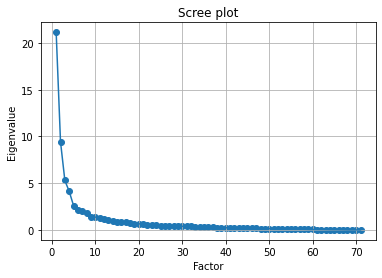

In [391]:
plt.scatter(range(1, len(ev)+1),ev)
plt.plot(range(1, len(ev)+1),ev)
plt.title('Scree plot')
plt.xlabel('Factor')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

> It seems like we have 13 factors that are significant(bigger than one eigenvalue).

In [392]:
fa = FactorAnalyzer()
fa.set_params(n_factors=13, rotation='varimax')
fa.fit(county_factor)

FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='minres', n_factors=13, rotation='varimax',
               rotation_kwargs={}, use_smc=True)

In [393]:
factor_loading = pd.DataFrame(fa.loadings_)

In [394]:
factor_loading.index = county_factor.columns

In [395]:
factor_loading.shape

(71, 13)

In [396]:
factor_loading

,0,1,2,3,4,5,6,7,8,9,10,11,12
density_km,-0.193705,0.092392,0.159963,0.159882,0.128229,-0.057597,0.359181,0.009880,0.213873,0.037656,0.086554,0.531145,0.028712
years_of_potential_life_lost_rate,0.884469,-0.140569,-0.103572,0.209515,0.017708,0.060640,0.010707,-0.039648,0.013123,0.136704,0.193110,-0.094091,-0.019756
percent_fair_or_poor_health,0.830871,0.279421,0.100796,0.188251,-0.069859,0.165342,-0.056582,0.114717,0.183586,0.029796,0.044450,-0.000907,0.110914
percent_low_birthweight,0.593336,-0.080959,0.076330,0.589135,0.009370,0.094780,0.019211,0.011457,0.047656,-0.133873,0.088933,0.016881,0.078947
percent_smokers,0.800194,-0.235241,-0.102286,0.048182,-0.024963,-0.081973,-0.055619,0.094095,0.174411,0.059025,-0.041962,-0.052174,0.146337
...,...,...,...,...,...,...,...,...,...,...,...,...,...
percent_hispanic,-0.080946,0.855996,0.134205,-0.052459,-0.023105,0.264815,0.109630,0.095898,-0.094805,-0.030986,0.017050,0.017880,0.089559
percent_non_hispanic_white,-0.193685,-0.564791,-0.265175,-0.606305,0.021065,-0.227585,-0.141715,-0.205327,0.049781,-0.088162,-0.092418,-0.126266,-0.085797
percent_not_proficient_in_english,-0.118769,0.861921,0.203454,0.007011,0.013730,0.169776,0.180029,0.077256,0.080217,0.014787,-0.039027,0.155149,0.000771
percent_female,0.056712,-0.067292,0.100529,0.343300,0.277941,0.004574,0.114350,-0.111497,0.209706,0.009455,0.129538,-0.206376,-0.056475


## Factor interpretation: 

Now that we have collected all the significant factors, let's interpret them one by one. We will look at columns that have decent loadings(>|0.3|) for easier interpretations.

In [397]:
def filter_decent_loadings(factor):
    return factor[(factor > 0.3) | (factor < -0.3)]

In [398]:
for factor in factor_loading.columns:
    print('Factor ' + str(factor + 1) + ' loadings: ')
    print()
    print(filter_decent_loadings(factor_loading[factor]))
    print()
    print()

Factor 1 loadings: 

years_of_potential_life_lost_rate                0.884469
percent_fair_or_poor_health                      0.830871
percent_low_birthweight                          0.593336
percent_smokers                                  0.800194
percent_adults_with_obesity                      0.619196
food_environment_index                          -0.694255
percent_physically_inactive                      0.720793
percent_with_access_to_exercise_opportunities   -0.556250
percent_excessive_drinking                      -0.575307
chlamydia_rate                                   0.393261
teen_birth_rate                                  0.792786
percent_uninsured                                0.333876
primary_care_physicians_rate                    -0.345394
dentist_rate                                    -0.354541
preventable_hospitalization_rate                 0.495405
percent_with_annual_mammogram                   -0.408047
percent_vaccinated                              -0.

1. The first factor seems to encompass a lot of indexes related to general well-being. Some of its most substantial positive loadings(> 0.8) are for the years of potential life lost rate, the percentage of fair or poor health, the percentage of smokers, the percentage of physical or mental distress, and child poverty percentage. Some of its most substantial negative loadings(< -0.7) are for median household income, life expectancy, general income, and college percentage. It explains a lot of variables connected to welfare in high coefficients. And its positive direction is towards poor welfare. Based on the loadings, I can identify this factor as **poor general well-being** with decent confidence.

2. The second factor has apparent connections to variables related to housing issues. Its biggest loadings(> 0.8) are for the percentage of severe housing problems, severe housing cost burden, and the percentage of severe housing cost burden. The percentage of homeowners has the lowest loadings for this factor. It is convincing that this factor is for **housing burden**.

3. The third factor seems to be connected to the prevalence of hispanic population. Its most substantial positive loadings(> 0.8) are for the percentage of hispanic population and the percentage of people not proficient in English. Its most vigorous negative factor loading is for the percentage of non-hispanic white population(~-0.54). Other variables, such as housing problems and youth population, with lower factor loadings also seem to make sense for hispanic population prevalence. As a result, I would determine this factor to be **hispanic relative population size**.  

4. The fourth factor is for **uninsured rate** because that's all its concerns with high loadings.

5. The fifth factor seems to be highly related to population density. Its highest loadings are for density in km(\~0.73), traffice volumn(\~0.60), and Asian population(\~0.58), while its lowest loadings are related to rural population and lone drive to work. It is clear that this factor is about **population density index**.

6. The sixth factor has mostly to do with care provider rates such as dentist and mental health(> 0.5). It seems to be inversely connected with rural percentage and long commute. Although its loadings are relatively weaker, we can probably conclude that it is for **care provider accessibility**.

7. The seventh factor seems to be mainly connected to black population. Its most significant loading is for the percentage of black population(~0.83). A lot of its other loadings are seemingly problems more common in black communities. Some examples are low birthweight, poor food environment, and single parent households. One of its negative loadings is the percentage of non-hispanic white population. I think we can determine that this factor is for **black relative population size**.

8. The eighth factor seems to be about the population age as the extreme youth percentage has a positive loading(> 0.55), and the senior percentage has a very negative loading(< -0.86). We can somewhat conclude that this factor is for **population youth**.

9. The ninth factor should be somewhat apparent, with its two biggest loadings being the percentage of American Indian Alaska Native(.75) and inadequate kitchen or plumbing facilities(0.7). We will determine this factor to be about **native relative population size**.

10. The tenth factor should have weak loadings overall. The theme seems to be about the middle and upper class income level as it includes median household income, 80th percentile income, long commute, and white household income. We will loosely define this factor to be about **middle to upper class income**.

11. The eleventh factor is quite difficult in terms of interpretation since its loadings are about lone drive to work, female percentage, vaccination and air pollution, which are seemingly unconnected to each other. We will take a closer look down below.

12. The twelfth factor is also straightforward as its loadings are mostly about food. We will determine it to be about **poor food environment index** due to its related variables and their directions.

13. The thirteenth factor is somewhat unclear. Its most significant loading has to do with fine particulate matter, and other loadings can be interpreted to be loosely related to that as well. As a result, we will determine that this factor is about **air pollution**.

> Please note that these interpreations are purely subjective and could be done better with more domain knowledge.

In [399]:
fa.get_factor_variance()

(array([19.13956906,  4.30850564,  4.24406839,  3.69916534,  3.50255935,
         3.31310357,  2.61406728,  2.22141095,  2.06210525,  1.78430854,
         1.55050626,  1.44032396,  1.27062916]),
 array([0.2695714 , 0.06068318, 0.05977561, 0.05210092, 0.04933182,
        0.04666343, 0.03681785, 0.03128748, 0.02904374, 0.02513111,
        0.02183812, 0.02028625, 0.01789619]),
 array([0.2695714 , 0.33025457, 0.39003018, 0.4421311 , 0.49146293,
        0.53812636, 0.57494421, 0.60623168, 0.63527542, 0.66040653,
        0.68224464, 0.7025309 , 0.72042708]))

> Together the 13 factors explain about 72% of the total variance.

Now with the factors interpreted, let's transform the original columns into our factors, name them and append `_factor` to the names. Then, we will merge the data back.

In [400]:
transformed_county_factor = pd.DataFrame(
    fa.transform(county_factor),
    columns=[
        'A',
        'B',
        'C',
        'D',
        'E',
        'F',
        'G',
        'H',
        'I',
        'J',
        'X',
        'Y',
        'Z'
    ]
)

In [401]:
county = county_non_factor.reset_index().join(transformed_county_factor)

# Exploratary analysis

In this section, we want to explore each factor's distribution and its relationship with the response variable. We will also compare the counties by their state governor parties. For the rest of the analysis, we will set the response variable as the infection rate at 45 days since the first case of a county.

In [402]:
county.sample(5)

,index,state,county,population,state_house_blue_perc,state_governor_party,days_counted,case_sum,death_sum,case_count_50_days,...,D,E,F,G,H,I,J,X,Y,Z
260,286,Georgia,Madison,27922,37.50,red,52,29,1,27,...,-0.449846,-1.336955,2.817058,-0.006056,-0.168783,1.340803,-0.429837,-0.478988,-0.385737,-1.486003
633,769,Missouri,Jefferson,218733,29.41,red,51,314,13,289,...,-0.893309,-1.006808,0.730277,0.267275,0.423693,0.725628,0.043328,1.418604,-1.295859,2.580441
1181,1398,Washington,Walla Walla,60760,59.18,blue,73,107,2,26,...,-0.758731,1.632394,-0.914732,-0.411293,0.051336,-0.787737,-0.027596,-0.269981,0.135810,-3.338830
601,705,Mississippi,Hancock,43929,30.77,red,59,75,10,61,...,-0.640270,-0.614275,1.880539,0.173074,-1.022853,1.335474,-0.362462,-0.133412,-0.292906,-0.662680
1162,1378,Washington,Franklin,95222,59.18,blue,58,531,16,279,...,0.344101,-0.905058,-2.078832,-1.311810,1.640240,-0.490245,1.910345,-1.152632,-0.804512,0.908351


In [403]:
county.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1242 entries, 0 to 1241
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   index                   1242 non-null   int64  
 1   state                   1242 non-null   object 
 2   county                  1242 non-null   object 
 3   population              1242 non-null   int64  
 4   state_house_blue_perc   1242 non-null   float64
 5   state_governor_party    1242 non-null   object 
 6   days_counted            1242 non-null   int64  
 7   case_sum                1242 non-null   int64  
 8   death_sum               1242 non-null   int64  
 9   case_count_50_days      1242 non-null   int64  
 10  death_count_50_days     1242 non-null   int64  
 11  infection_rate          1242 non-null   float64
 12  death_rate              1242 non-null   float64
 13  infection_rate_50_days  1242 non-null   float64
 14  death_rate_50_days      1242 non-null   

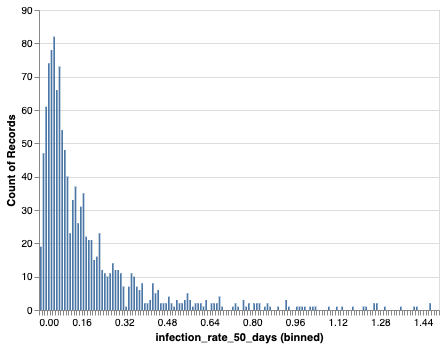

In [405]:
alt.Chart(county).mark_bar().encode(
    alt.X("infection_rate_50_days", bin=alt.Bin(extent=[0, 1.5], step=0.01)),
    y='count()',
)

> It looks like we have a bit of a right skewness for the response variable distribution.

In [406]:
county[county['state_governor_party'] == 'blue'].corr(method='pearson')['infection_rate_50_days']

index                    -0.035123
population                0.072772
state_house_blue_perc    -0.005117
days_counted              0.069922
case_sum                  0.505018
death_sum                 0.512710
case_count_50_days        0.685629
death_count_50_days       0.607066
infection_rate            0.968516
death_rate                0.111430
infection_rate_50_days    1.000000
death_rate_50_days        0.045067
A                        -0.042773
B                         0.138227
C                         0.177962
D                         0.292754
E                        -0.027458
F                         0.017477
G                        -0.003588
H                        -0.100813
I                         0.271374
J                         0.000967
X                         0.177822
Y                         0.138026
Z                         0.048325
Name: infection_rate_50_days, dtype: float64

> Looks like we have overall poor correlations for blue counties. The most positive one(\~0.05) is the factor for air pollution, while the more significant negative ones(< -0.05) are factors for middle to upper class income, population youth and uninsured rate.

In [407]:
county[county['state_governor_party'] == 'red'].corr(method='pearson')['infection_rate_50_days']

index                    -0.140595
population               -0.057969
state_house_blue_perc    -0.026627
days_counted             -0.013633
case_sum                  0.146359
death_sum                 0.091149
case_count_50_days        0.219791
death_count_50_days       0.131934
infection_rate            0.978972
death_rate                0.038721
infection_rate_50_days    1.000000
death_rate_50_days       -0.000456
A                         0.095176
B                        -0.033056
C                         0.062431
D                         0.153752
E                        -0.101998
F                        -0.076809
G                        -0.087022
H                         0.016930
I                        -0.000328
J                         0.012750
X                        -0.076119
Y                         0.090445
Z                         0.037873
Name: infection_rate_50_days, dtype: float64

> Looks like we also have poor correlations for red counties. The more positive ones(> 0.05) are the factors for poor general well-being, hispanic population. The more negative ones(< -0.05) are uninsured rate and care provider accessibility.

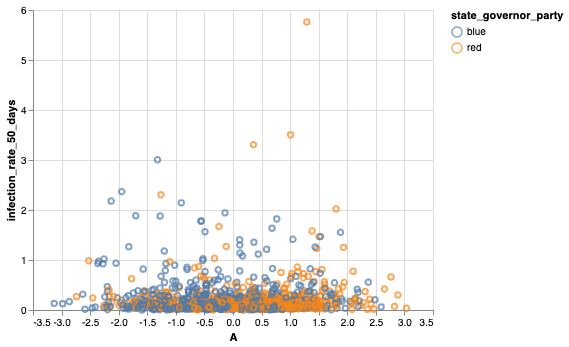

In [408]:
alt.Chart(county).mark_point().encode(
    x='A',
    y='infection_rate_50_days',
    color='state_governor_party'
)

In [409]:
mod = smf.ols(
    formula=' '.join([
        'infection_rate_50_days ~',
        '+ A*state_governor_party',
        '+ B*state_governor_party',
        '+ C*state_governor_party',
        '+ D*state_governor_party',
        '+ E*state_governor_party',
        '+ F*state_governor_party',
        '+ G*state_governor_party',
        '+ H*state_governor_party',
        '+ I*state_governor_party',
        '+ J*state_governor_party',
        '+ X*state_governor_party',
        '+ Y*state_governor_party',
        '+ Z*state_governor_party'
    ]), 
    data=county
)

In [410]:
res = mod.fit()

In [411]:
print(res.summary())

                              OLS Regression Results                              
Dep. Variable:     infection_rate_50_days   R-squared:                       0.166
Model:                                OLS   Adj. R-squared:                  0.147
Method:                     Least Squares   F-statistic:                     8.931
Date:                    Thu, 14 May 2020   Prob (F-statistic):           1.40e-32
Time:                            15:22:06   Log-Likelihood:                -389.85
No. Observations:                    1242   AIC:                             835.7
Df Residuals:                        1214   BIC:                             979.2
Df Model:                              27                                         
Covariance Type:                nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------